# Import Dependensi dan Variabel

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Import Data

In [8]:
df_gravimetri = pd.read_csv('hasil/ET Aktual Gravimetri.csv')
df_bc = pd.read_csv('hasil/Estimasi ET Blaney-Criddle.csv')
df_hs = pd.read_csv('hasil/Estimasi ET Hargreaves-Samani.csv')
df_pm = pd.read_csv('hasil/Estimasi ET Penman-Monteith.csv')

# Visualisasi Hasil Gravimetri

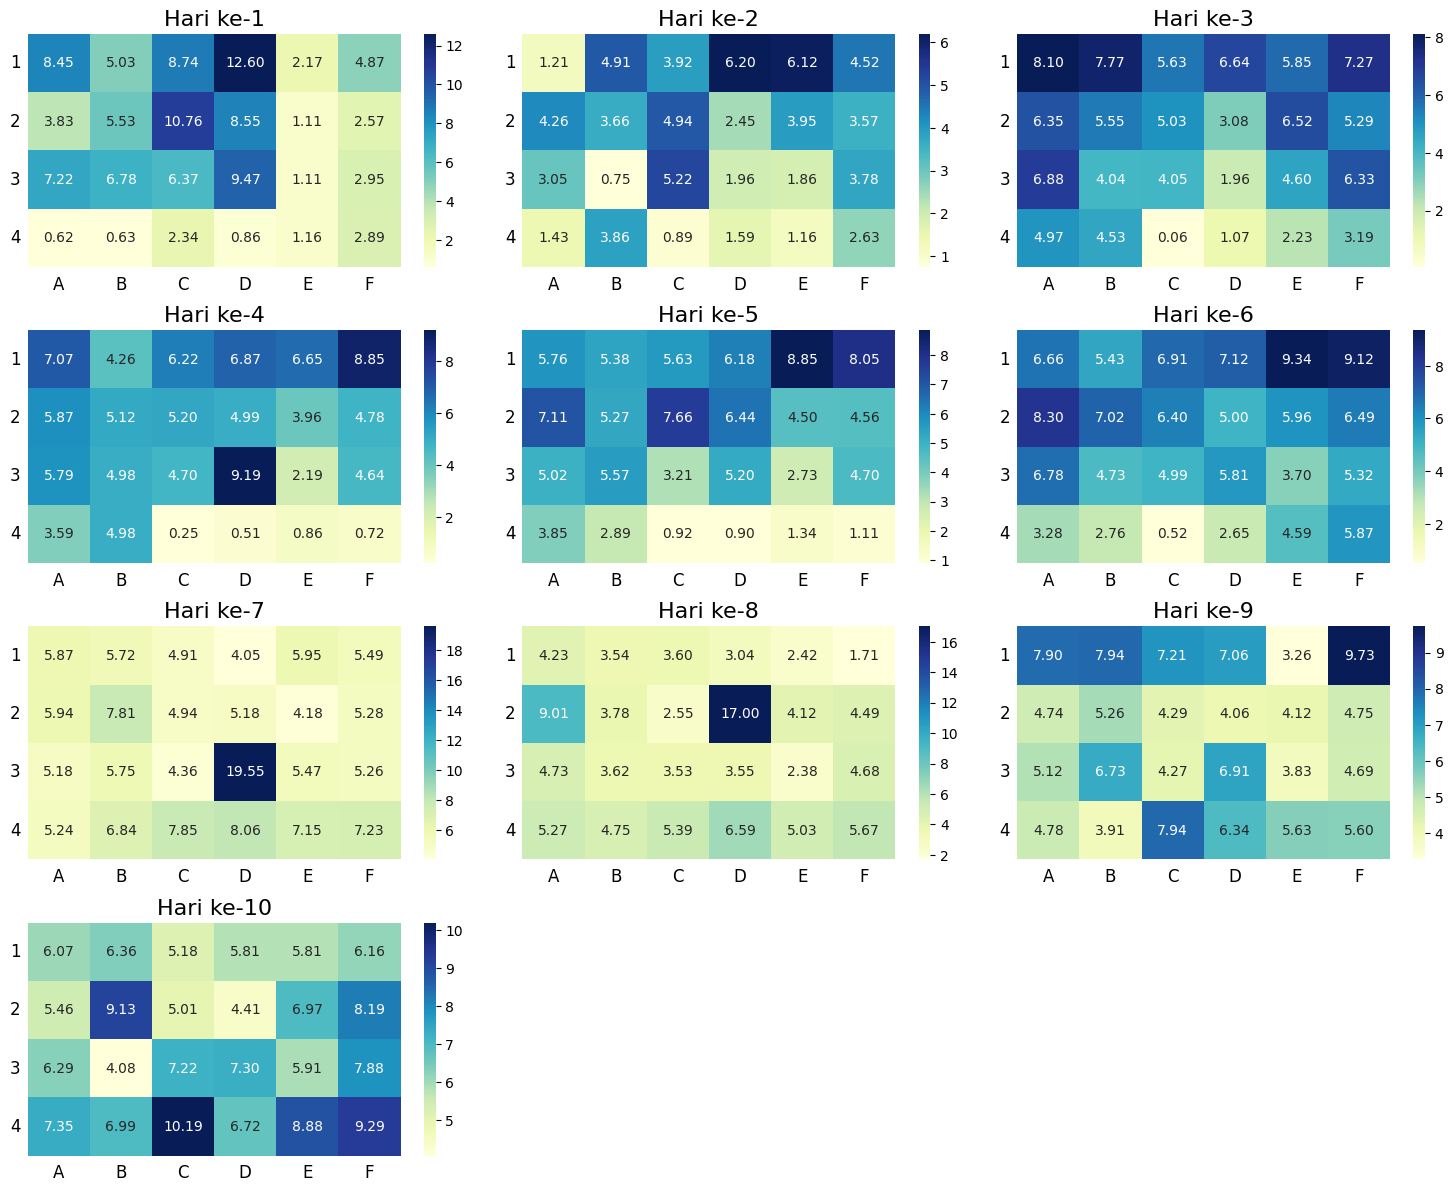

In [9]:
df_gravimetri.set_index('Num Day', inplace=True)

# Plot heatmaps
fig, axes = plt.subplots(4, 3, figsize=(15, 12))  # 4x3 grid
axes = axes.flatten()

for i, (day, data) in enumerate(df_gravimetri.iterrows()):
    # Reshape data untuk heatmap
    day_data = data.values.reshape(4, 6)  # Reshape ke (4x6)
    
    # Plot heatmap
    sns.heatmap(
        day_data, annot=True, fmt=".2f", cmap="YlGnBu",
        xticklabels=[], yticklabels=[], ax=axes[i]
    )
    axes[i].set_title(f"Hari ke-{i+1}", fontsize=16)

    # Tambahkan label X (A-F) dan Y (1-4)
    for col in range(6):
        axes[i].text(col + 0.5, 4.3, f"{chr(65 + col)}", ha="center", va="center", fontsize=12)
    for row in range(4):
        axes[i].text(-0.2, row + 0.5, f"{row + 1}", ha="center", va="center", fontsize=12)

# Hilangkan subplot kosong jika jumlah hari kurang dari 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Hitung Data Boxplot

In [10]:
df_bc = df_bc.reset_index(drop=True)
df_bc.index = df_bc.index + 1

df_hs = df_hs.reset_index(drop=True)
df_hs.index = df_hs.index + 1

df_pm = df_pm.reset_index(drop=True)
df_pm.index = df_pm.index + 1

In [11]:
# Menghitung rata-rata harian dari semua tanaman
df_gravimetri['Average_ET'] = df_gravimetri.iloc[:, 1:].mean(axis=1)

# Menghitung Standar Deviasi untuk setiap hari
df_gravimetri['STD_ET'] = df_gravimetri.iloc[:, 1:-1].std(axis=1)

# Menghitung IQR (Interquartile Range) untuk setiap hari
Q1 = df_gravimetri.iloc[:, 1:-2].quantile(0.25, axis=1)
Q3 = df_gravimetri.iloc[:, 1:-2].quantile(0.75, axis=1)
df_gravimetri['IQR_ET'] = Q3 - Q1

# Menghitung median untuk setiap hari
df_gravimetri['Median_ET'] = df_gravimetri.iloc[:, 1:-3].median(axis=1)

df_gravimetri.head()

,A1,A2,A3,A4,B1,B2,B3,B4,C1,C2,...,E3,E4,F1,F2,F3,F4,Average_ET,STD_ET,IQR_ET,Median_ET
Num Day,,,,,,,,,,,,,,,,,,,,,
day 05,8.4480,5.0304,8.7360,12.5952,2.173333,4.866667,3.826667,5.533333,10.755918,8.551837,...,0.622222,0.628148,2.3376,0.8592,1.1616,2.8896,4.701868,3.548835,5.333783,3.826667
day 06,1.2084,4.9140,3.9156,6.2004,6.124667,4.524667,4.258000,3.658000,4.935551,2.447388,...,1.428370,3.863926,0.8940,1.5948,1.1580,2.6268,3.333533,1.619656,2.483565,3.658000
day 07,8.1024,7.7664,5.6256,6.6432,5.853333,7.273333,6.346667,5.546667,5.030204,3.075918,...,4.968889,4.530370,0.0552,1.0680,2.2296,3.1896,4.733976,2.031907,2.724691,5.030204
day 08,7.0656,4.2624,6.2208,6.8736,6.653333,8.853333,5.866667,5.120000,5.201633,4.986122,...,3.591111,4.977778,0.2496,0.5088,0.8640,0.7200,4.572448,2.405562,2.054002,4.977778
day 09,5.7612,5.3772,5.6268,6.1836,8.847333,8.047333,7.107333,5.267333,7.662980,6.443388,...,3.854000,2.891037,0.9204,0.9012,1.3356,1.1076,4.654579,2.276581,2.855806,5.015250


In [12]:
df_gravimetri_analisis = df_gravimetri[['Average_ET', 'STD_ET', 'IQR_ET', 'Median_ET']].copy()
df_gravimetri_analisis.rename(columns={'Average_ET': 'Rata-rata', 'STD_ET': 'STDEV', 'IQR_ET': 'IQR', 'Median_ET': 'Median'}, inplace=True)
df_gravimetri_analisis = df_gravimetri_analisis.reset_index(drop=True)
df_gravimetri_analisis.index = df_gravimetri_analisis.index + 1
df_gravimetri_analisis = df_gravimetri_analisis.round(3)
df_gravimetri_analisis.head()

,Rata-rata,STDEV,IQR,Median
1,4.702,3.549,5.334,3.827
2,3.334,1.620,2.484,3.658
3,4.734,2.032,2.725,5.030
4,4.572,2.406,2.054,4.978
5,4.655,2.277,2.856,5.015


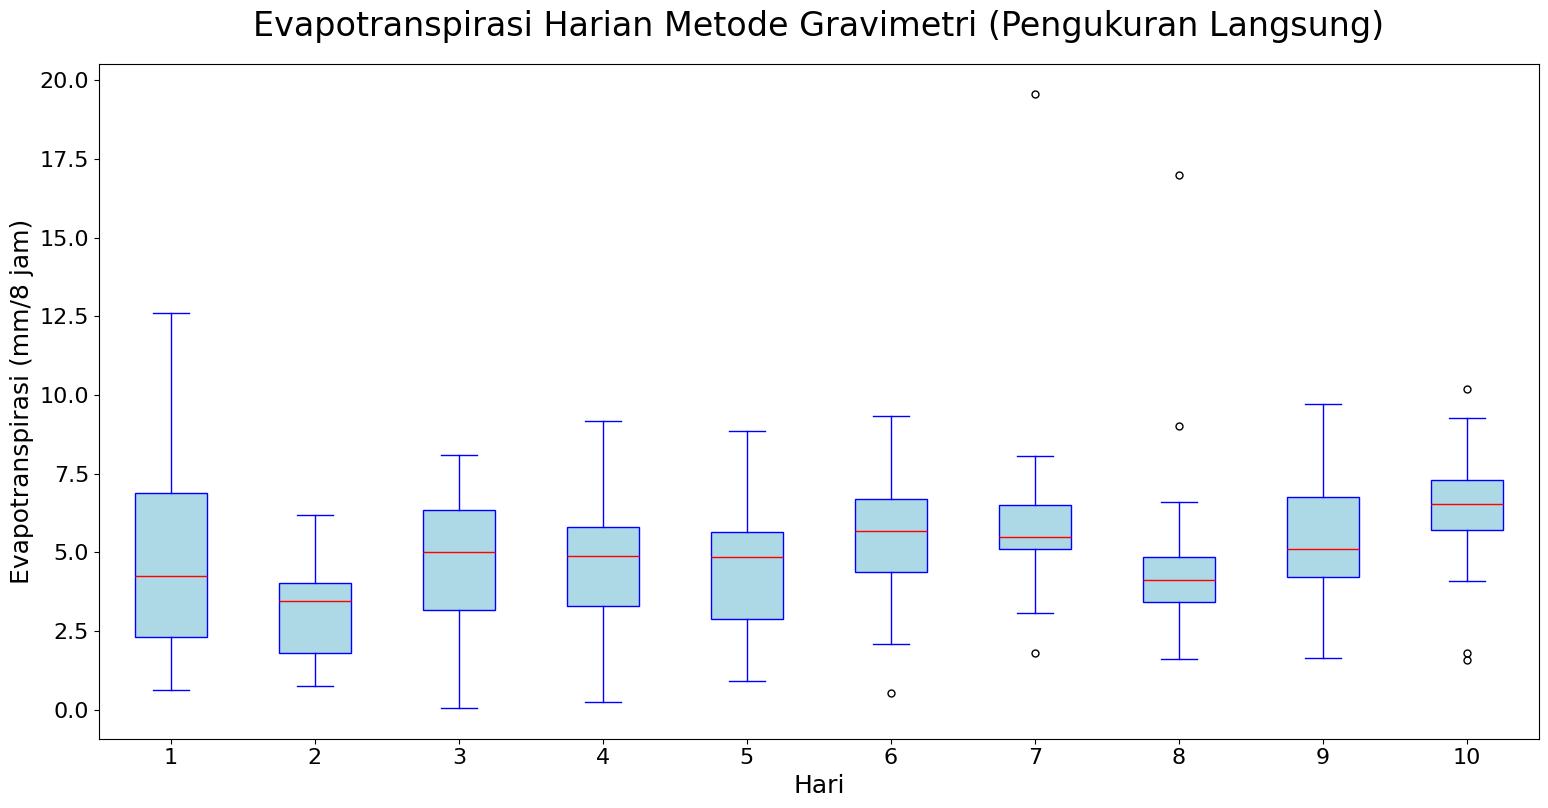

In [13]:
# Reset index to make 'Num Day' a column again
df_gravimetri_reset = df_gravimetri.reset_index()

# Convert df_gravimetri to long format
data_aktual_long = df_gravimetri_reset.melt(id_vars=['Num Day'], var_name='Day', value_name='Evapotranspirasi')

# Membuat plot boxplot dengan ukuran besar
fig, ax = plt.subplots(figsize=(18, 9))  # Ukuran figure diperbesar
boxplot = data_aktual_long.boxplot(by='Num Day', column='Evapotranspirasi', grid=False, patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='blue'),
           capprops=dict(color='blue'),
           medianprops=dict(color='red'),
           flierprops=dict(marker='o', color='red', markersize=5),
           ax=ax)

# Tambahkan judul dan label
ax.set_title('Evapotranspirasi Harian Metode Gravimetri (Pengukuran Langsung)', fontsize=24, pad=20)
ax.set_xlabel('Hari', fontsize=18)
ax.set_ylabel('Evapotranspirasi (mm/8 jam)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Ubah keterangan sumbu x menjadi angka 1 sampai 10
ax.set_xticklabels(range(1, 11))

plt.suptitle('')

# Tampilkan plot
plt.show()


# Plot Gravimetri

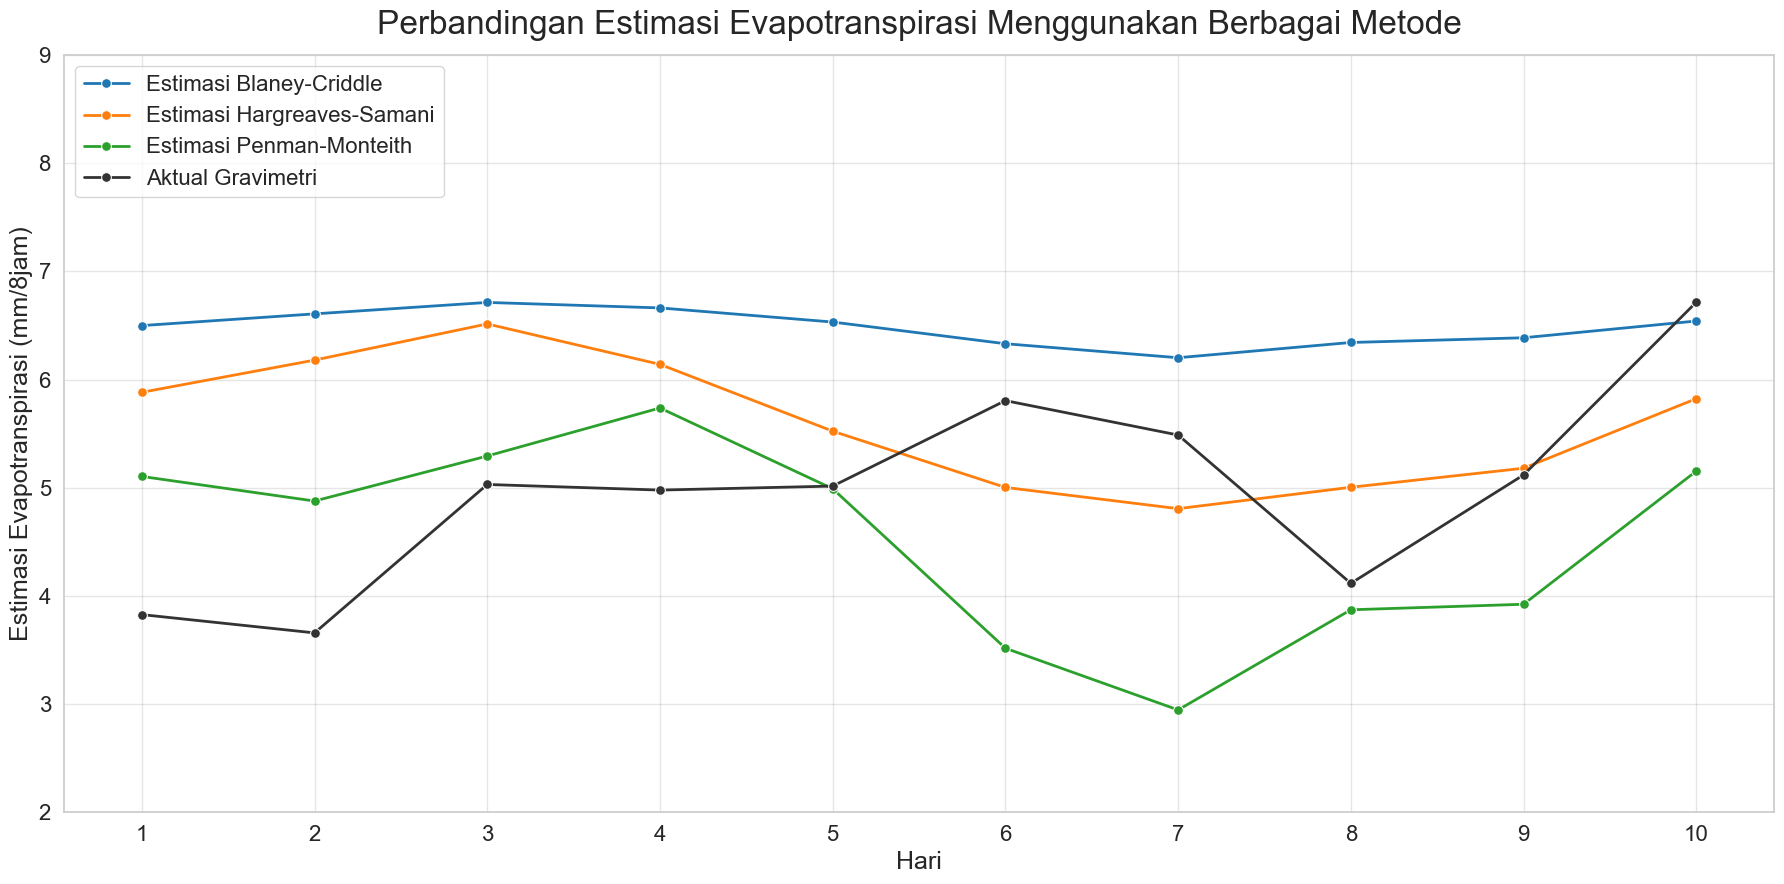

In [14]:
sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(18, 9))

# Plot data Blaney-Criddle
sns.lineplot(
  x=df_bc.index, y=df_bc['ET Total'], marker='o', label='Estimasi Blaney-Criddle', color='#1f77b4', markersize=7, linewidth=2)

# Plot data Hargreaves-Samani
sns.lineplot(x=df_hs.index, y=df_hs['ET Total'], marker='o', label='Estimasi Hargreaves-Samani', color='#ff7f0e', markersize=7, linewidth=2)

# Plot data Penman-Monteith 
sns.lineplot(x=df_pm.index, y=df_pm['ET Total'], marker='o', label='Estimasi Penman-Monteith', color='#2ca02c', markersize=7, linewidth=2)

# Plot data gravimetri
sns.lineplot(x=df_gravimetri_analisis.index, y=df_gravimetri_analisis['Median'], marker='o', label='Aktual Gravimetri', color='#333333', markersize=7, linewidth=2)

plt.title('Perbandingan Estimasi Evapotranspirasi Menggunakan Berbagai Metode', fontsize=24, pad=15)
plt.xlabel('Hari', fontsize=18)
plt.ylabel('Estimasi Evapotranspirasi (mm/8jam)', fontsize=18)
plt.xticks(np.arange(1, 10 + 1, 1), fontsize=16)  # Rentang 1 untuk label x
plt.yticks(fontsize=16)

plt.grid(True, linestyle='-', color='gray', alpha=0.2)
plt.legend(
  fontsize=16, 
  frameon=True,
  loc='upper left',
)
plt.ylim(2, 9)
plt.tight_layout()
plt.show()

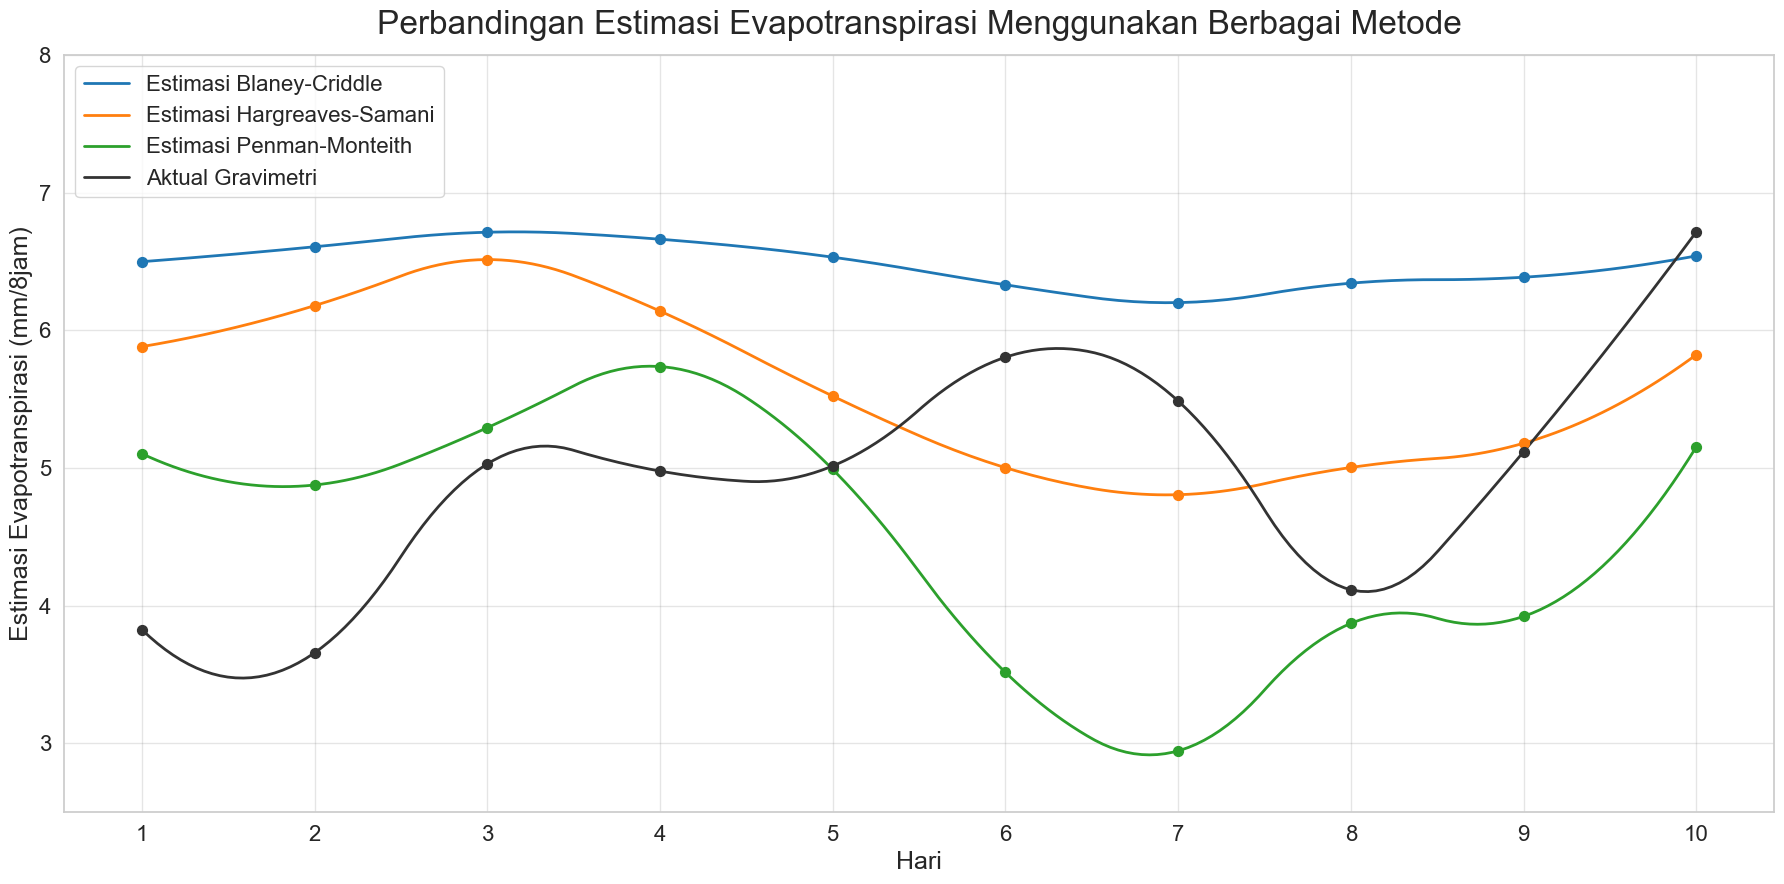

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

sns.set(style="whitegrid", palette="Set2")
plt.figure(figsize=(18, 9))

# Fungsi untuk membuat kurva melengkung dengan spline interpolasi
def smooth_curve(x, y, num_points=200):
    x_new = np.linspace(x.min(), x.max(), num_points)
    spline = make_interp_spline(x, y, k=2)  # k=3 untuk cubic spline
    y_smooth = spline(x_new)
    return x_new, y_smooth

# Plot data Blaney-Criddle
x_bc, y_bc = smooth_curve(df_bc.index, df_bc['ET Total'])
plt.plot(x_bc, y_bc, label='Estimasi Blaney-Criddle', color='#1f77b4', linewidth=2)
plt.scatter(df_bc.index, df_bc['ET Total'], color='#1f77b4', s=50, zorder=3)

# Plot data Hargreaves-Samani
x_hs, y_hs = smooth_curve(df_hs.index, df_hs['ET Total'])
plt.plot(x_hs, y_hs, label='Estimasi Hargreaves-Samani', color='#ff7f0e', linewidth=2)
plt.scatter(df_hs.index, df_hs['ET Total'], color='#ff7f0e', s=50, zorder=3)

# Plot data Penman-Monteith
x_pm, y_pm = smooth_curve(df_pm.index, df_pm['ET Total'])
plt.plot(x_pm, y_pm, label='Estimasi Penman-Monteith', color='#2ca02c', linewidth=2)
plt.scatter(df_pm.index, df_pm['ET Total'], color='#2ca02c', s=50, zorder=3)

# Plot data gravimetri
x_grav, y_grav = smooth_curve(df_gravimetri_analisis.index, df_gravimetri_analisis['Median'])
plt.plot(x_grav, y_grav, label='Aktual Gravimetri', color='#333333', linewidth=2)
plt.scatter(df_gravimetri_analisis.index, df_gravimetri_analisis['Median'], color='#333333', s=50, zorder=3)

# Judul dan label sumbu
plt.title('Perbandingan Estimasi Evapotranspirasi Menggunakan Berbagai Metode', fontsize=24, pad=15)
plt.xlabel('Hari', fontsize=18)
plt.ylabel('Estimasi Evapotranspirasi (mm/8jam)', fontsize=18)

# Menentukan ticks pada sumbu x dengan interval 1
x_min = min(df_bc.index.min(), df_hs.index.min(), df_pm.index.min(), df_gravimetri_analisis.index.min())
x_max = max(df_bc.index.max(), df_hs.index.max(), df_pm.index.max(), df_gravimetri_analisis.index.max())
plt.xticks(np.arange(x_min, x_max + 1, 1), fontsize=16)  # Rentang 1 untuk label x

plt.yticks(fontsize=16)

# Grid dan legenda
plt.grid(True, linestyle='-', color='gray', alpha=0.2)
plt.legend(fontsize=16, frameon=True, loc='upper left')

# Rentang sumbu y
plt.ylim(2.5, 8)
plt.tight_layout()

# Tampilkan grafik
plt.show()

In [16]:
df_gravimetri_analisis

,Rata-rata,STDEV,IQR,Median
1,4.702,3.549,5.334,3.827
2,3.334,1.620,2.484,3.658
3,4.734,2.032,2.725,5.030
4,4.572,2.406,2.054,4.978
5,4.655,2.277,2.856,5.015
6,5.568,2.099,2.183,5.805
7,6.408,3.090,1.812,5.487
8,4.802,3.086,1.613,4.116
9,5.573,1.638,2.540,5.118
10,6.808,1.591,1.803,6.715


In [17]:
df_analisis_parameter = df_gravimetri_analisis[['Median']].copy()
df_analisis_parameter.rename(columns={'Median': 'Gravimetri'}, inplace=True)

df_analisis_parameter.loc[:, 'Blaney-Criddle'] = df_bc['ET Total']
df_analisis_parameter.loc[:, 'Hargreaves-Samani'] = df_hs['ET Total']
df_analisis_parameter.loc[:, 'Penman-Monteith'] = df_pm['ET Total']
df_analisis_parameter

,Gravimetri,Blaney-Criddle,Hargreaves-Samani,Penman-Monteith
1,3.827,6.498712,5.881888,5.104162
2,3.658,6.606921,6.179544,4.876762
3,5.030,6.712646,6.514070,5.293068
4,4.978,6.662035,6.140098,5.737096
5,5.015,6.531469,5.522609,4.990299
6,5.805,6.330886,5.002684,3.516000
7,5.487,6.201563,4.806410,2.945929
8,4.116,6.342530,5.004103,3.871651
9,5.118,6.386000,5.180139,3.922581
10,6.715,6.540940,5.823144,5.153486


# Fungsi Analisis Parameter

In [18]:
# Fungsi menghitung akurasi
def calculate_akurasi(aktual, estimasi):
  error = np.abs(np.mean(estimasi) - np.mean(aktual)) / np.mean(aktual)
  akurasi = (1 - error) * 100
  return akurasi

In [19]:
# Fungsi untuk menghitung RMSE
def calculate_rmse(actual, estimates):
    return np.sqrt(mean_squared_error(actual, estimates))

In [20]:
# Fungsi untuk menghitung MAE
def calculate_mae(actual, estimates):
    return mean_absolute_error(actual, estimates)

In [21]:
# Fungsi untuk menghitung MBE
def calculate_mbe(actual, estimates):
    return np.mean(estimates - actual)

# Analisis Parameter

In [22]:
# Menghitung Akurasi, RMSE, MAE, dan MBE untuk setiap metode
results = {
    'Metode': ['Blaney-Criddle', 'Hargreaves-Samani', 'Penman-Monteith'],
    'Akurasi': [],
    'RMSE': [],
    'MAE': [],
    'MBE': []
}

# Define the actual values
actual = df_analisis_parameter['Gravimetri']

for column in results['Metode']:
    results['Akurasi'].append(calculate_akurasi(actual, df_analisis_parameter[column]))
    results['RMSE'].append(calculate_rmse(actual, df_analisis_parameter[column]))
    results['MAE'].append(calculate_mae(actual, df_analisis_parameter[column]))
    results['MBE'].append(calculate_mbe(actual, df_analisis_parameter[column]))

# Membuat dataframe dari hasil perhitungan
df_results = pd.DataFrame(results)
df_results = df_results.round(3)
df_results

,Metode,Akurasi,RMSE,MAE,MBE
0,Blaney-Criddle,69.719,1.766,1.541,1.506
1,Hargreaves-Samani,87.325,1.307,1.106,0.631
2,Penman-Monteith,91.280,1.392,1.137,-0.434
